# Классификация изображений



### Установка зависимостей

In [ ]:
!pip install -U torch torchvision

In [ ]:
!pip install wheel==0.34.1

In [ ]:
# установка подходящей версии torch

from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [ ]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
# нам необходима версия pillow  5.3.0
# удалим старую версию и установим новую
!pip uninstall -y Pillow
!pip install Pillow==5.3.0
import PIL
print(PIL.PILLOW_VERSION)
# здесь должна быть версия 5.3.0. если это не так перехгрузите данный ноутбук:
# Menu > Runtime > Restart Runtime

# ***RESTART !!!***

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

In [ ]:
# ИСПРАВЛЕНИЕ
#!unzip -q /content/gdrive/My\ Drive/simpsons/data/dataset.zip -d train
#!unzip -q /content/gdrive/My\ Drive/simpsons/data/testset.zip -d test

!unzip -q /content/gdrive/My\ Drive/journey-springfield.zip

In [ ]:
!ls train

simpsons_dataset


In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Wed Nov 30 13:16:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import datasets, models, transforms
import torch.optim as optim
from torch.optim import lr_scheduler

from collections import Counter
import time

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [ ]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
##### Augmentations !!!!!!!!
##### Augmentations !!!!!!!!
##### Augmentations !!!!!!!!

In [ ]:
import pandas as pd

train_labels = [path.parent.name for path in train_val_files]
data = pd.Series(train_labels).value_counts().sort_values().to_frame("count")
data

In [ ]:
from torchvision import datasets, transforms

augmentations = transforms.RandomChoice([
    transforms.Compose([
        transforms.Resize(size=300, max_size=301),
        transforms.CenterCrop(size=300),
        transforms.RandomCrop(250)
    ]),
    transforms.RandomRotation(degrees=(-25, 25)),
    transforms.RandomHorizontalFlip(p=1),
])
train_transforms = transforms.Compose([
    augmentations,
    transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
    transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ,
])
train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transforms)

In [ ]:
from torch.utils.data.sampler import WeightedRandomSampler
from collections import Counter

BATCH_SIZE = 256
RESCALE_SIZE = 224
N_CORES = 2

class_count = Counter(train_dataset.targets)
class_weights = {i: 1/c for i, c in class_count.items()}
sample_weights = [0] * len(train_dataset)
for i, (data, label) in enumerate(tqdm(train_dataset)):
    class_weight = class_weights[label]
    sample_weights[i] = class_weight

N = max(class_count.values()) * len(class_count)  # fit to max
train_sampler = WeightedRandomSampler(sample_weights, num_samples=N, replacement=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers=N_CORES)

100%|██████████| 20933/20933 [02:52<00:00, 121.25it/s]


In [ ]:
count = Counter()
for data, labels in tqdm(train_loader):
    count += Counter(labels.tolist())
print(sum(count.values()), count)

100%|██████████| 369/369 [10:55<00:00,  1.78s/it]

94332 Counter({20: 2339, 14: 2329, 32: 2322, 25: 2316, 4: 2312, 39: 2305, 0: 2301, 26: 2299, 29: 2295, 18: 2291, 12: 2277, 11: 2273, 5: 2268, 2: 2265, 34: 2262, 27: 2262, 40: 2261, 19: 2249, 36: 2248, 22: 2247, 41: 2242, 15: 2234, 24: 2233, 17: 2233, 13: 2230, 28: 2230, 16: 2227, 1: 2226, 10: 2225, 8: 2224, 35: 2214, 31: 2214, 33: 2214, 23: 2210, 7: 2206, 21: 2201, 37: 2198, 38: 2192, 6: 2190, 9: 2167, 30: 2155, 3: 2146})


In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

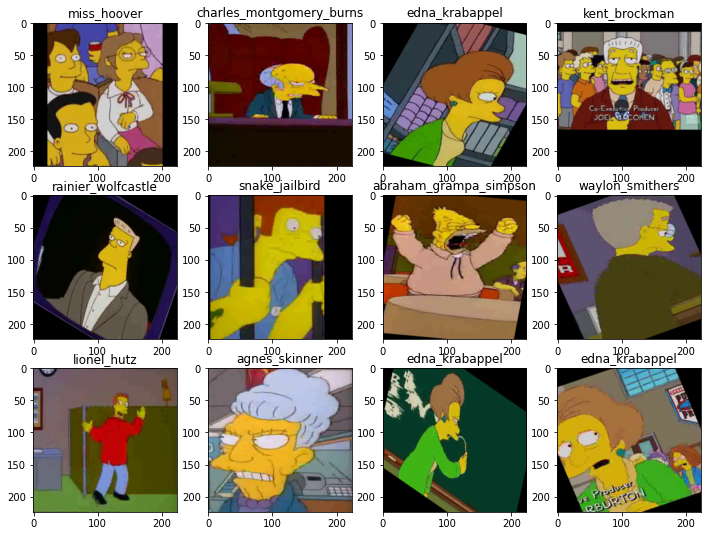

In [ ]:
axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 9))[1]
data, labels = next(iter(train_loader))
for ax, d, l in zip(axes.flatten(), data, labels):
    imshow(d.data.cpu(), title=train_dataset.classes[l], plt_ax=ax)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [ ]:
# BASELINE MODEL

# # Очень простая сеть
# class SimpleCnn(nn.Module):

#     def __init__(self, n_classes):
#         super().__init__()
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )
#         self.conv2 = nn.Sequential(
#             nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )
#         self.conv3 = nn.Sequential(
#             nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )
#         self.conv4 = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )
#         self.conv5 = nn.Sequential(
#             nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
#         )

#         self.out = nn.Linear(96 * 5 * 5, n_classes)


#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = self.conv3(x)
#         x = self.conv4(x)
#         x = self.conv5(x)

#         x = x.view(x.size(0), -1)
#         logits = self.out(x)
#         return logits

*Курсив*## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать.

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову:


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)


In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
class SimpsonsDataset_Trans(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    # + добавленна возможность реализации собственного transform

    def __init__(self, files, mode, transform = None):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
        self.label_encoder = LabelEncoder()

        if self.mode != "test":
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                pickle.dump(self.label_encoder, le_dump_file)
        if transform is None:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transform

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        if self.mode != 'train':
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = self.transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def fit_epoch(model, train_loader, optimizer, criterion):
    run_correct = 0 # Количество верных предсказаний, для подсчета лосса
    run_loss = 0 # куммулятивный лосс
    processed_data = 0 # общее число обработанных сэмплов, для подсчета лосса.(Напрямую из лоадера не вытащить?)
    model.train()
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        output = model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(output, 1)
        run_loss += loss.item() * inputs.size(0)
        run_correct += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = run_loss / processed_data
    train_acc = run_correct.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)

    val_loss = running_loss / processed_size
    val_acc = running_corrects.cpu().numpy() / processed_size # double()
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size, sampler = None):
    if sampler is None:
        train_loader = DataLoader(train_files, batch_size = batch_size, shuffle = True)
    else:
        train_loader = DataLoader(train_files, batch_size = batch_size, sampler = sampler)
    val_loader = DataLoader(val_files, batch_size = batch_size, shuffle = False)

    history = []
    log_template = "\nEpoch: {ep:03d} train_loss: {t_loss:0.4f} train_accuracy: {t_acc:0.4f}\
    val_loss: {v_loss:0.4f} val_accuracy: {v_acc:0.4f}"

    with tqdm(desc = "epoch", total = epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=3e-4)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, opt, criterion)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                          v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
val_dataset = SimpsonsDataset_Trans(val_files, mode='val')

train_dataset = SimpsonsDataset_Trans(train_files, mode='train')

In [ ]:
train_labels = [path.parent.name for path in train_val_files]
tr_labels_count = pd.Series(train_labels).value_counts()

class_weights = {label: 1./c for label, c in tr_labels_count.items()}
class_weights
sample_weights = [0] * len(train_dataset)
for i, (data, label) in enumerate(tqdm(train_dataset)):
    label_1 = train_dataset.label_encoder.inverse_transform([label])[0]
    class_weight = class_weights.get(label_1)
    sample_weights[i] = class_weight


sampler = WeightedRandomSampler(sample_weights, num_samples = 2*len(train_dataset))

  0%|          | 0/15699 [00:00<?, ?it/s]

In [ ]:
train_loader = DataLoader(train_dataset, batch_size = 100, sampler = sampler)
x = pd.DataFrame()
for _, labels in train_loader:
    lbls = [train_dataset.label_encoder.inverse_transform([label])[0] for label in labels]
    label_count = pd.Series(lbls, index=lbls, name='count').value_counts()
    x = x.append(label_count)
x.head()

,gil,bart_simpson,martin_prince,chief_wiggum,edna_krabappel,marge_simpson,principal_skinner,krusty_the_clown,patty_bouvier,professor_john_frink,...,lisa_simpson,disco_stu,moe_szyslak,ralph_wiggum,milhouse_van_houten,miss_hoover,sideshow_bob,comic_book_guy,ned_flanders,otto_mann
count,7.0,6.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN
count,5.0,NaN,1.0,1.0,1.0,5.0,NaN,2.0,4.0,2.0,...,3.0,3.0,2.0,1.0,2.0,2.0,2.0,5.0,1.0,1.0
count,2.0,1.0,5.0,2.0,3.0,6.0,4.0,1.0,3.0,3.0,...,1.0,4.0,2.0,NaN,3.0,3.0,5.0,1.0,2.0,3.0
count,3.0,2.0,3.0,1.0,3.0,3.0,NaN,1.0,3.0,NaN,...,1.0,1.0,6.0,2.0,5.0,NaN,1.0,2.0,3.0,3.0
count,2.0,8.0,3.0,2.0,1.0,1.0,2.0,7.0,NaN,3.0,...,1.0,1.0,2.0,2.0,4.0,NaN,2.0,5.0,3.0,2.0


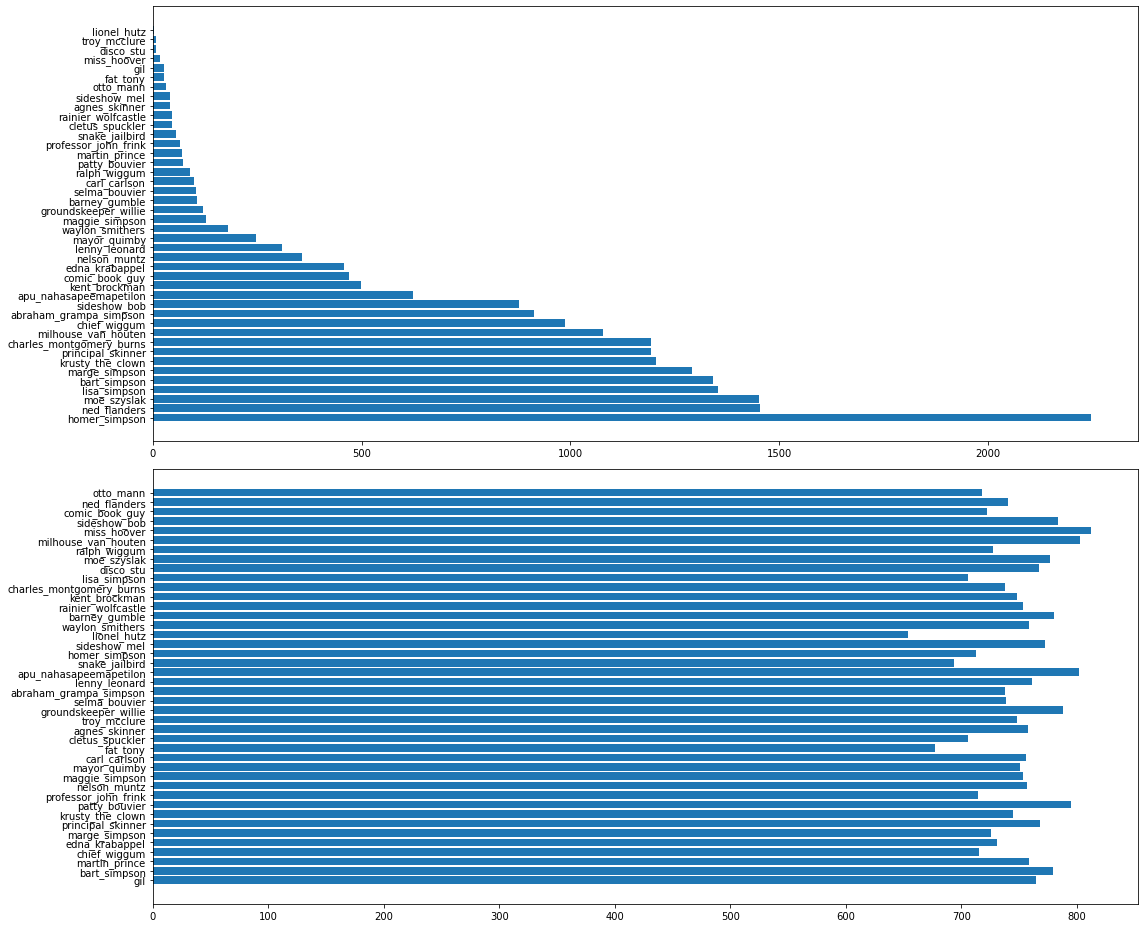

In [ ]:
x = x.fillna(value=0)
y = x.sum(axis = 0)
fig, ax = plt.subplots(2, 1, figsize = (16,13))
ax[0].barh(tr_labels_count.index, tr_labels_count)
ax[1].barh(y.index, y)
fig.tight_layout()
plt.show()

# Добавили батчнорм к слоям.

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_layer = nn.Sequential(
        nn.BatchNorm2d(in_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )

    def forward(self, x):
        x = self.conv_layer(x)
        return x

class SimpleCNN(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = ConvBlock(in_channels = 3, out_channels = 8)
        self.conv2 = ConvBlock(in_channels = 8, out_channels = 16)
        self.conv3 = ConvBlock(in_channels = 16, out_channels = 32)
        self.conv4 = ConvBlock(in_channels = 32, out_channels = 64)
        self.conv5 = ConvBlock(in_channels = 64, out_channels = 96)
        self.out = nn.Linear(96 * 5 * 5, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [ ]:
#Отрисовка графиков обучения, accuracy & loss
def visualize_loss_acc(history):
    loss, acc, val_loss, val_acc = zip(*history)
    fig, ax = plt.subplots(1, 2, figsize = (20,10))

    ax[0].plot(loss, label="train_loss")
    ax[0].plot(val_loss, label="val_loss")
    ax[0].legend(loc='best')
    ax[0].set_xlabel("epochs")
    ax[0].set_ylabel("loss")

    ax[1].plot(acc, label="train_acc")
    val_accuracy = [i.item() for i in val_acc]
    ax[1].plot(val_accuracy, label="val_acc")
    ax[1].legend(loc='best')
    ax[1].set_xlabel("epochs")
    ax[1].set_ylabel("accuracy")
    plt.show()

In [ ]:
torch.manual_seed(42)
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCNN(n_classes).to(DEVICE)
print("we will classify :{} classes".format(n_classes))
simple_cnn

we will classify :42 classes


SimpleCNN(
  (conv1): ConvBlock(
    (conv_layer): Sequential(
      (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (conv2): ConvBlock(
    (conv_layer): Sequential(
      (0): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (conv3): ConvBlock(
    (conv_layer): Sequential(
      (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (conv4): ConvBlock(
    (conv_layer): 

In [ ]:
history_01 = train(train_dataset, val_dataset, model=simple_cnn, epochs=10, batch_size=64)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 2.518433057591371

Epoch: 001 train_loss: 2.5184 train_accuracy: 0.3230    val_loss: 1.9069 val_accuracy: 0.4943
loss 1.569041584508344

Epoch: 002 train_loss: 1.5690 train_accuracy: 0.5795    val_loss: 1.4731 val_accuracy: 0.6024
loss 1.2145235677898079

Epoch: 003 train_loss: 1.2145 train_accuracy: 0.6690    val_loss: 1.2638 val_accuracy: 0.6624
loss 0.9925901974999333

Epoch: 004 train_loss: 0.9926 train_accuracy: 0.7274    val_loss: 1.1307 val_accuracy: 0.6949
loss 0.8376339400518517

Epoch: 005 train_loss: 0.8376 train_accuracy: 0.7707    val_loss: 1.0640 val_accuracy: 0.7144
loss 0.7235956053208664

Epoch: 006 train_loss: 0.7236 train_accuracy: 0.8033    val_loss: 0.9745 val_accuracy: 0.7423
loss 0.6256781228219364

Epoch: 007 train_loss: 0.6257 train_accuracy: 0.8345    val_loss: 0.9283 val_accuracy: 0.7549
loss 0.5467172191016832

Epoch: 008 train_loss: 0.5467 train_accuracy: 0.8566    val_loss: 0.9084 val_accuracy: 0.7558
loss 0.47268981525522713

Epoch: 009 train_loss: 0

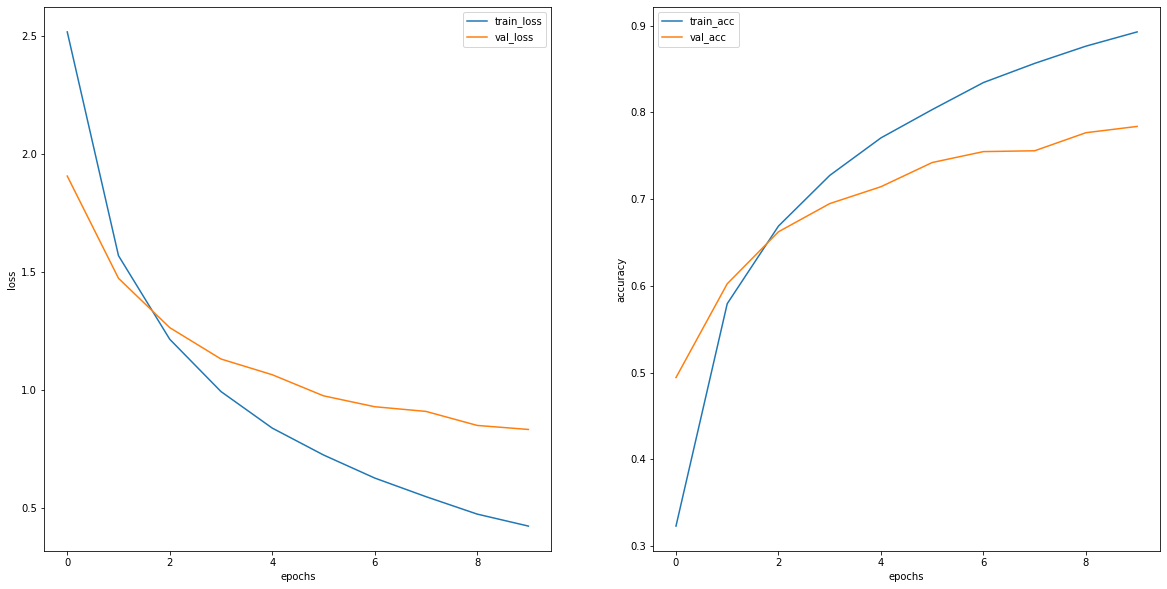

In [ ]:
visualize_loss_acc(history_01)

# Вставили два двусвязных слоя в classifier, без аугментации и сэмплинга

In [ ]:
class SimpleCNN2fc(SimpleCNN):
    def __init__(self, n_classes):
        super().__init__(n_classes)

        self.out = nn.Sequential(
            nn.Linear(96 * 5 * 5, 2048),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(2048, n_classes),
        )

    def forward(self, x):
        return super().forward(x)

In [ ]:
fc_net = SimpleCNN2fc(n_classes).to(DEVICE)
fc_net

SimpleCNN2fc(
  (conv1): ConvBlock(
    (conv_layer): Sequential(
      (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (conv2): ConvBlock(
    (conv_layer): Sequential(
      (0): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (conv3): ConvBlock(
    (conv_layer): Sequential(
      (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (conv4): ConvBlock(
    (conv_layer

In [ ]:
history_03 = train(train_dataset, val_dataset, model=fc_net, epochs=20, batch_size=64)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 2.1982774251706663

Epoch: 001 train_loss: 2.1983 train_accuracy: 0.3974    val_loss: 1.5378 val_accuracy: 0.5678
loss 1.3617672273304608

Epoch: 002 train_loss: 1.3618 train_accuracy: 0.6176    val_loss: 1.1280 val_accuracy: 0.6806
loss 1.032894503835645

Epoch: 003 train_loss: 1.0329 train_accuracy: 0.7070    val_loss: 0.8997 val_accuracy: 0.7591
loss 0.8225966854774008

Epoch: 004 train_loss: 0.8226 train_accuracy: 0.7679    val_loss: 0.8232 val_accuracy: 0.7784
loss 0.6639853023166785

Epoch: 005 train_loss: 0.6640 train_accuracy: 0.8108    val_loss: 0.7210 val_accuracy: 0.8049
loss 0.5383718287563604

Epoch: 006 train_loss: 0.5384 train_accuracy: 0.8441    val_loss: 0.6748 val_accuracy: 0.8173
loss 0.4488088355371015

Epoch: 007 train_loss: 0.4488 train_accuracy: 0.8674    val_loss: 0.6247 val_accuracy: 0.8284
loss 0.36446128273148454

Epoch: 008 train_loss: 0.3645 train_accuracy: 0.8925    val_loss: 0.6650 val_accuracy: 0.8263
loss 0.30384328298465757

Epoch: 009 train_loss:

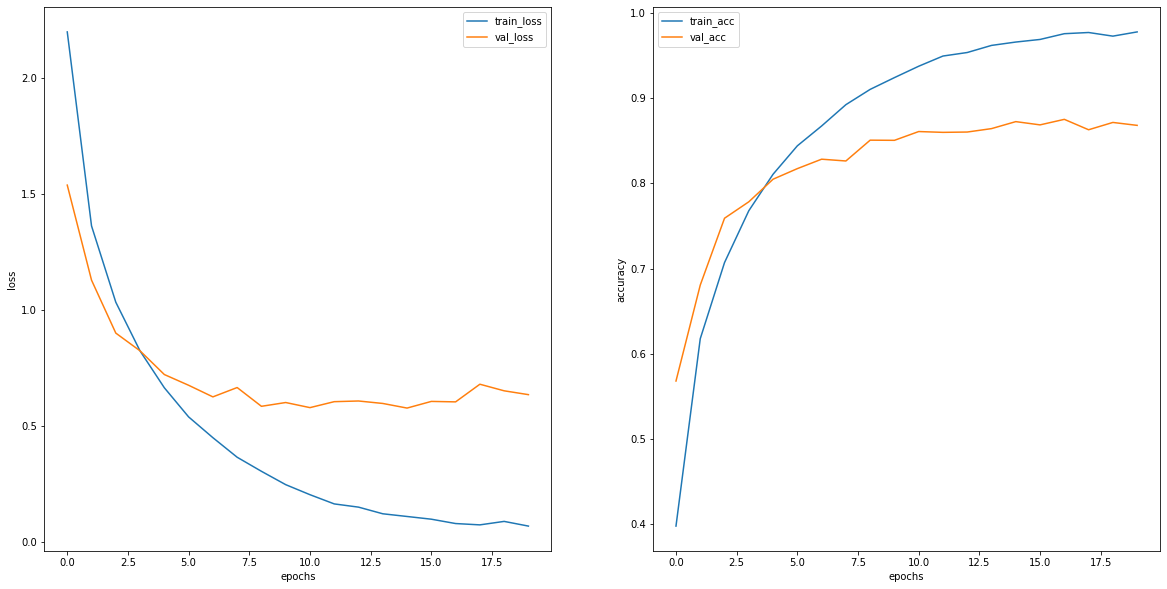

In [ ]:
visualize_loss_acc(history_03)

In [ ]:
test_dataset = SimpsonsDataset_Trans(test_files, mode='test')
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=30)
test_filenames = [path.name for path in test_dataset.files]
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
probs_3 = predict(fc_net, test_loader)
preds_3 = label_encoder.inverse_transform(np.argmax(probs_3, axis=1))
submit_3 = pd.DataFrame({'Id': test_filenames, 'Expected': preds_3})
submit_3.to_csv('submission_3_fc_net.csv', index=False)

In [ ]:
# Kaggle: 0.96493

# Файнтюнинг ResNet18

In [ ]:
model_resnet18_2 = models.resnet18(pretrained=True).to(DEVICE)
model=model_resnet18_2

num_ftrs = model.fc.in_features   # 512
model.fc = nn.Linear(num_ftrs, n_classes)

model = model.to(DEVICE)

for name, p in model.named_parameters():
    if name.startswith("layer4.1.") or name.startswith("fc."):
        p.requires_grad = True
    else:
        p.requires_grad = False

    print("param name:", name, "requires_grad:", p.requires_grad)

param name: conv1.weight requires_grad: False
param name: bn1.weight requires_grad: False
param name: bn1.bias requires_grad: False
param name: layer1.0.conv1.weight requires_grad: False
param name: layer1.0.bn1.weight requires_grad: False
param name: layer1.0.bn1.bias requires_grad: False
param name: layer1.0.conv2.weight requires_grad: False
param name: layer1.0.bn2.weight requires_grad: False
param name: layer1.0.bn2.bias requires_grad: False
param name: layer1.1.conv1.weight requires_grad: False
param name: layer1.1.bn1.weight requires_grad: False
param name: layer1.1.bn1.bias requires_grad: False
param name: layer1.1.conv2.weight requires_grad: False
param name: layer1.1.bn2.weight requires_grad: False
param name: layer1.1.bn2.bias requires_grad: False
param name: layer2.0.conv1.weight requires_grad: False
param name: layer2.0.bn1.weight requires_grad: False
param name: layer2.0.bn1.bias requires_grad: False
param name: layer2.0.conv2.weight requires_grad: False
param name: layer2

In [ ]:
history = train(train_dataset, val_dataset, model=model, epochs=20, batch_size=64)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 0.9576506434986489

Epoch: 001 train_loss: 0.9577 train_accuracy: 0.7776    val_loss: 0.5051 val_accuracy: 0.8777
loss 0.2601822689313237

Epoch: 002 train_loss: 0.2602 train_accuracy: 0.9462    val_loss: 0.3740 val_accuracy: 0.9058
loss 0.0711623135769289

Epoch: 003 train_loss: 0.0712 train_accuracy: 0.9919    val_loss: 0.3362 val_accuracy: 0.9165
loss 0.021133980289205063

Epoch: 004 train_loss: 0.0211 train_accuracy: 0.9993    val_loss: 0.3092 val_accuracy: 0.9238
loss 0.009012476849881728

Epoch: 005 train_loss: 0.0090 train_accuracy: 0.9997    val_loss: 0.3022 val_accuracy: 0.9272
loss 0.006908735556333272

Epoch: 006 train_loss: 0.0069 train_accuracy: 0.9997    val_loss: 0.3000 val_accuracy: 0.9251
loss 0.0033752029604375263

Epoch: 007 train_loss: 0.0034 train_accuracy: 1.0000    val_loss: 0.2975 val_accuracy: 0.9257
loss 0.002199983943453795

Epoch: 008 train_loss: 0.0022 train_accuracy: 1.0000    val_loss: 0.2970 val_accuracy: 0.9293
loss 0.0016399033486459167

Epoch: 00

In [ ]:
history_04 = history

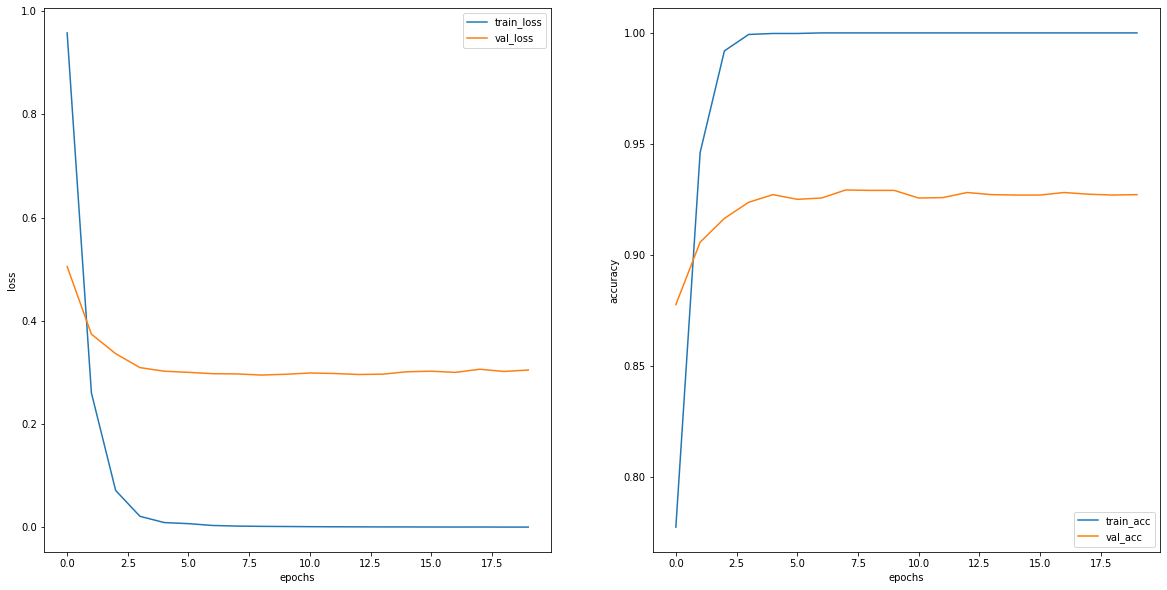

In [ ]:
visualize_loss_acc(history_04)

In [ ]:
probs_4 = predict(model, test_loader)
preds_4 = label_encoder.inverse_transform(np.argmax(probs_4, axis=1))
submit_4 = pd.DataFrame({'Id': test_filenames, 'Expected': preds_4})
submit_4.to_csv('submission_4.csv', index=False)

In [ ]:
# Kaggle: 0.96599